# This is the script to extract Liver bounding!

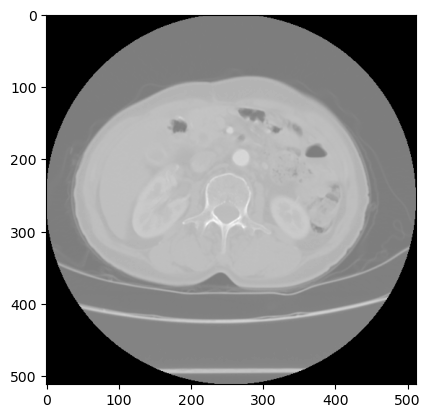

In [9]:
import pydicom

# 指定DICOM文件路径
file_path = '../../Data/CT_Phase/Abomends_Data/test/1.2.840.113619.2.359.3.2831208971.139.1569975591.560.54.dicom'

# 读取DICOM文件
ds = pydicom.dcmread(file_path)

# 打印DICOM文件的一些信息

# 访问特定的DICOM标签
# 例如，获取患者的名字和图像大小
patient_name = ds.PatientName
image_size = ds.pixel_array.shape

#print(f"Patient Name: {patient_name}")
#show array


import matplotlib.pyplot as plt
plt.imshow(ds.pixel_array, cmap='gray')




In [ ]:
ds.

In [2]:
import os
import nibabel as nib
import pandas as pd
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
#len(os.listdir('../../Data/CT_Phase/Full_Image_Liver_07075/'))

In [4]:
import os
import nibabel as nib
import numpy as np
import skimage 
import matplotlib.pyplot as plt
from tqdm import tqdm
import SimpleITK as sitk
import nibabel as nib
import math
#print(os.listdir('../../Test_Data/Test_3D/'))
class ImageLoad:
    def __init__(self,input_path):
        """
        The path should only contain images
        """
        self.input_path = input_path


        #self.images_names = os.listdir('../../Test_Data/Test_3D/')
        self.images_names = os.listdir(self.input_path)
        self.images_num = len(self.images_names)
        self.image_path = [self.input_path + name for name in self.images_names]

    def image_load(self,image_path,reader='nib'):
        if reader == 'nib':
            return nib.load(image_path)
        elif reader == 'sitk':
            return sitk.ReadImage(image_path)
        else:
            raise ValueError("The reader should be either nib or sitk!")
        
    #def image_get_float(self):

  


class LiverBoundingBox:
    def __init__(self,liver_mask,liver_orig,out_path_box=None,file_name=None):
        """
        args:
            liver_mask: the liver mask|nib or sitk
            original_image: the original image|nib or sitk
        """
        self.liver_seg = liver_mask
        self.liver_orig = liver_orig
        self.out_path_box = out_path_box
        self.file_name = file_name
        # self.original_image = original_image
        # self.liver_mask_array = self._get_array(liver_seg)
        # self.original_arrary = self._get_array(original_image)
        # self.image_loader = image_loader
    def extract_liver(self,liver=True):
        """
            get either the liver or tumor region from the mask
            args:
                mask: mask of the liver and tumor
                liver: if True return the liver region, if False return the tumor region
        """
        mask = self._get_array(self.liver_seg)
        mask = mask.astype(int)
        print(mask.shape)
        
        if liver:
            mask[mask == 2] = 1
        else:
            mask[mask == 1] = 0
            mask[mask == 2] = 1
            mask = mask.astype(int)
            
        # only keep the largest connected component
        labeled = skimage.measure.label(mask, connectivity=2)

        labeled[labeled != 1] = 0
      
        mask = labeled
        print(mask.sum())

        return mask


        
    def get_liver_bounding_box(self,liver_mask):
        '''
    Function to generate bounding box for liver, from a binary liver mask
        args:
            liver_mask: binary mask of the liver

        returns:
            bbox: bounding box of the liver (min_row, min_col, min_slice, max_row, max_col, max_slice = bbox)
        '''

        # get the image_probs
        image_probs = skimage.measure.regionprops((liver_mask))

        # get the bounding box of the liver

        if len(image_probs) == 0:
            print(f'[WARNING] no liver found')
            self._recording_failing()
            return None

        ## find the adjacent box that contains the liver
        for props in image_probs:
            bbox = props.bbox
            min_row, min_col, min_slice, max_row, max_col, max_slice = bbox 
            print("this is range",min_row, min_col, min_slice, max_row, max_col, max_slice)
        return [min_row, min_col, min_slice, max_row, max_col, max_slice]

    def crop_scan(self,liver_bounding):
        """
        Crop the scan with the bounding box
        args:
            liver_bounding: the bounding box of the liver
        """
        liver_original = self._get_array(self.liver_orig)
        # get the bounding box of the liver
        min_row, min_col, min_slice, max_row, max_col, max_slice = list(map(self._check_range,liver_bounding))
        print('this is after check range',min_row, min_col, min_slice, max_row, max_col, max_slice)
        
        #crop the scan
        cropped_scan = liver_original[min_row:max_row,min_col:max_col,min_slice:max_slice]
        return cropped_scan
    
    def store_cropped_data(self,cropped_data):

        if not os.path.exists(self.out_path_box):
            os.mkdir(self.out_path_box)
            print('The path does not exist, create the path!')

        header = self.liver_orig.header
        affine = self.liver_orig.affine
        print("this is shape of cropped data",cropped_data.shape)
        cropped_image = nib.Nifti1Image(cropped_data, affine, header)


        
        nib.save(cropped_image, self.out_path_box + self.file_name)

    @staticmethod   
    def liver_detection(mask):
        if np.count_nonzero(mask) != 0:
            return True


    def _check_range(self,range_num):
        return max(0,range_num)
    
    def _get_array(self,image_file):
        return image_file.get_fdata()
    
    def _recording_failing(self):
        with open(self.out_path_box + 'failing_box.txt','a') as f:
            f.write(self.file_name + '\n')








In [15]:
cropped_out_path = '../../Data/Mixed_HGP/Miexed_HGP_Liver_Cropped/'
#load the images
image_orig_load = ImageLoad("../../Data/Mixed_HGP/Mixed_HGP/")
image_seg_load = ImageLoad("../../Data/Mixed_HGP/Mxied_HGP_mask/")
for i in range(image_orig_load.images_num):
    file_name = image_orig_load.images_names[i]
    image_orign,image_segg = image_orig_load.image_load(image_orig_load.image_path[i]),image_seg_load.image_load(image_seg_load.image_path[i])

    #finding bounding box
    liver_bbox = LiverBoundingBox(image_segg,image_orign,cropped_out_path,file_name)
    liver_mask = liver_bbox.extract_liver()
    if liver_bbox.liver_detection(liver_mask):
        liver_box_range = liver_bbox.get_liver_bounding_box(liver_mask)
        image_liver_slice[file_name] = liver_box_range
        
    else:
        liver_bbox._recording_failing()

(512, 512, 125)
1866050
this is range 54 127 31 362 394 119
(512, 512, 210)
1511161
this is range 62 132 127 319 388 206
(512, 512, 112)
834015
this is range 61 143 72 330 424 111
(512, 512, 311)
2214422
this is range 48 127 113 353 419 213
(512, 512, 238)
813494
this is range 95 140 99 318 369 164
(512, 512, 127)
470052
this is range 101 177 48 380 372 79
(512, 512, 487)
2401518
this is range 59 183 337 314 456 483
(512, 512, 307)
2827191
this is range 38 164 0 336 425 99
(512, 512, 147)
748637
this is range 80 139 87 325 364 137
(512, 512, 207)
852150
this is range 89 171 0 324 389 41
(512, 512, 154)
845486
this is range 70 137 94 296 379 152
(512, 512, 48)
951640
this is range 46 140 5 387 419 43
(512, 512, 529)
2408434
this is range 73 147 349 345 382 509
(512, 512, 125)
657709
this is range 43 125 49 328 374 80
(512, 512, 142)
776687
this is range 59 140 86 322 383 141
(512, 512, 116)
861668
this is range 58 121 0 349 368 36
(512, 512, 38)
503390
this is range 67 131 7 383 352 36


In [93]:
import ast
liver_info = pd.DataFrame(pd.read_table('../../Data/Mixed_HGP/True_Label/Mixed_HGP_Slice_info.txt',sep=' ',header=None))

new_columns =[]

for index, row in liver_info.iterrows():
    range_lst = row[1:].tolist()
    range_lst = ' '.join(range_lst)
    range_lst = ast.literal_eval(range_lst)
    min_row,min_col,min_slice,max_row,max_col,max_slice = zip(range_lst)
    new_columns.append({'min_row':min_row[0],
                        'min_col':min_col[0],
                        'min_slice':min_slice[0],
                        'max_row':max_row[0],
                        'max_col':max_col[0],
                        'max_slice':max_slice[0]})

df = pd.DataFrame(new_columns)
#join the df with the original df

liver_info = pd.concat([liver_info,df],axis=1)
#DELETE 1,2,3,4,5,6column

liver_info.drop(columns=[1,2,3,4,5,6],inplace=True)

In [96]:
#set the first column to Experiment

Mixed_Data = pd.read_csv('../../Data/Mixed_HGP/True_Label/scans_used_all_info.csv')
Experiment_name = Mixed_Data['Experiment'].values.tolist()

liver_info[0] = Experiment_name
#change colum name
liver_info.rename(columns={0:'Experiment'},inplace=True)


In [98]:
liver_info.to_csv('../../Data/Mixed_HGP/True_Label/Mixed_HGP_Slice_info.csv',index=False)

In [120]:
import torch
import torch.nn.functional as F

# 模拟输入数据和标签（二元分类）
inputs = torch.randn(5, 1)  # 5个样本，每个样本1个预测值
labels = torch.tensor([0, 1, 1, 0, 1], dtype=torch.float32)  # 真实标签，转换为浮点数

# 将输入通过sigmoid函数转换为概率
inputs = torch.sigmoid(inputs)




In [129]:
import torch
import torch.nn.functional as F

# 模拟输入数据和标签（假设是多标签二元分类问题）
inputs = torch.randn(5, 2)  # 5个样本，每个样本有2个预测值

labels = torch.tensor([[1, 0], [0, 1], [0, 1], [1, 0], [0, 1]], dtype=torch.float32)  # 真实标签，转换为浮点数
labels_2 = torch.tensor([0,1,1,0,1])
# 将输入通过sigmoid函数转换为概率
inputs = torch.sigmoid(inputs)

# 计算二元交叉熵损失
loss = F.binary_cross_entropy(inputs, labels_2)


print(loss)


ValueError: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 2])) is deprecated. Please ensure they have the same size.

In [145]:
inputs_2 = torch.tensor(inputs[:,1],dtype=torch.float32)
labels_2 = torch.tensor(labels_2,dtype=torch.float32)

C:\Users\098986\AppData\Local\Temp\ipykernel_4552\3294135671.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs_2 = torch.tensor(inputs[:,1],dtype=torch.float32)
C:\Users\098986\AppData\Local\Temp\ipykernel_4552\3294135671.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_2 = torch.tensor(labels_2,dtype=torch.float32)


In [152]:

loss_2 = torch.nn.CrossEntropyLoss()(inputs[:,0],labels_2)


In [153]:
loss_2

tensor(4.9785)

In [9]:
def save_liver_slice(image_path,image_name,cropped_out_path,slice_margin=0):
    """
    args:
        image_path: the path of the image
        image_name: the name of the image
        slice_margin: the margin of the slice
    """
    image = nib.load(image_path)
    image_data = image.get_fdata()
    image_shape = image_data.shape
    print(image_shape,666)
    min_row, min_col, min_slice, max_row, max_col, max_slice = image_liver_slice[image_name]
    print('min and max slice',min_slice,max_slice)
    min_slice = max(0,math.floor(min_slice - min_slice*slice_margin))
    print('fucking max slice',max_slice)
    max_slice = min(image_shape[2],math.ceil(max_slice + max_slice* slice_margin))
    print("fucking after",max_slice)
    print(min_slice,max_slice)
    image_data = image_data[:,:,min_slice:max_slice]
    print(image_data.shape)
    image = nib.Nifti1Image(image_data, image.affine, image.header)
    nib.save(image, cropped_out_path + '/' + image_name)
    print('saved!')

In [18]:
image_orign = nib.load('../../Data/CT_Phase/Full_Image_Liver_07075/CILM_CT_101040_0000.nii.gz')
image_orign.shape

(521, 521, 112)

# Get Liver 07073 images


In [123]:
import pandas as pd
liver_info = pd.read_csv('../../Data/Mixed_HGP/True_Label/Mixed_HGP_Slice_info.csv')
liver_info
image_folder = '../../Data/Mixed_HGP/Mixed_HGP_Raw/'


Mixed_HGP_Data = os.listdir('../../Data/Mixed_HGP/Mixed_HGP_Raw/')

Mixed_HGP_Data = [os.path.abspath(os.path.join(image_folder, f)) for f in os.listdir(image_folder)]

output_folder = '../../Data/Mixed_HGP/Mixed_HGP_Only_Liver/'
for index,row in liver_info.iterrows():
    img = sitk.ReadImage(Mixed_HGP_Data[index])
    img_array = sitk.GetArrayFromImage(img)
    out_name = os.path.basename(Mixed_HGP_Data[index])
    min_row,min_col,min_slice,max_row,max_col,max_slice = row.iloc[1:]


    extracted_slices = img_array[min_slice:max_slice,min_col:max_col, min_row:max_row]
    output_path = os.path.join(output_folder, out_name)
    extracted_img = sitk.GetImageFromArray(extracted_slices)
    extracted_img.SetSpacing(img.GetSpacing())
    extracted_img.SetDirection(img.GetDirection())
    extracted_img.SetOrigin(img.GetOrigin())

    # 保存提取的切片
    sitk.WriteImage(extracted_img, output_path)
    

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x000002C88023A240> >

# Windowing

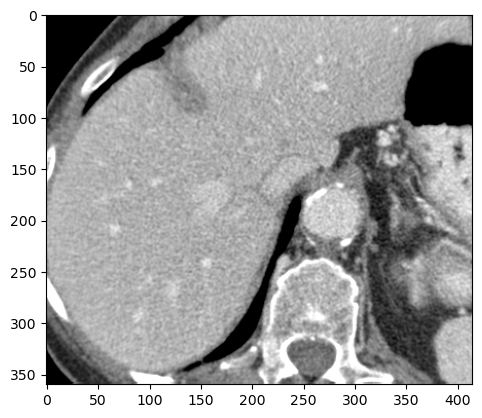

In [80]:
def apply_window_to_volume(batched_volumes, window_center, window_width):
    """
    Apply windowing to a batch of 3D volumes.
    :param batched_volumes: The input batch of 3D volumes.
    :param window_center: The center of the window (window level).
    :param window_width: The width of the window.
    :return: Windowed batch of 3D volumes.
    """
    lower_bound = window_center - window_width / 2
    upper_bound = window_center + window_width / 2
    windowed_batched_volumes = np.clip(batched_volumes, lower_bound, upper_bound)
    return windowed_batched_volumes

image = sitk.ReadImage("../../Data/Mixed_HGP/Mixed_HGP_Only_Liver_07073/CILM_CT_100330_0000.nii.gz")
image = sitk.GetArrayFromImage(image)

windowed_image = apply_window_to_volume(image, 50, 400)

plt.imshow(windowed_image[20,:,:], cmap='gray')

In [139]:
#windows the image
windowed_imgs = os.listdir('../../Data/Mixed_HGP/Mixed_HGP_Only_Liver_07073/')
windowed_imgs = [os.path.abspath(os.path.join('../../Data/Mixed_HGP/Mixed_HGP_Only_Liver_07073/', f)) for f in os.listdir('../../Data/Mixed_HGP/Mixed_HGP_Only_Liver_07073/')]

output_folder = '../../Data/Mixed_HGP/Mixed_HGP_Only_Liver_07073_Windowed/'
#os.mkdir(output_folder)
for index,img in enumerate(windowed_imgs):
    image = sitk.ReadImage(img)
    image_array = sitk.GetArrayFromImage(image)
    out_name = os.path.basename(img)
    output_path = os.path.join(output_folder, out_name)

    windowed_image = apply_window_to_volume(image_array, 50, 400)
    
    
    windowed_image = sitk.GetImageFromArray(windowed_image)
    windowed_image.SetSpacing(image.GetSpacing())
    windowed_image.SetDirection(image.GetDirection())
    windowed_image.SetOrigin(image.GetOrigin())
    sitk.WriteImage(windowed_image, output_path)
    
    

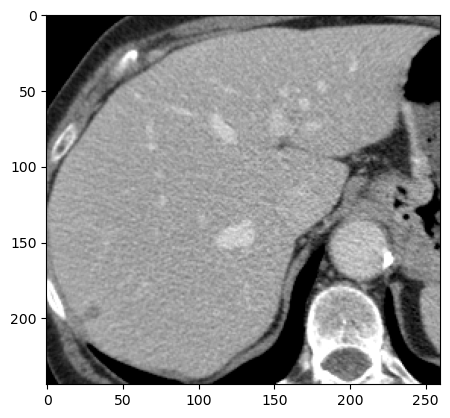

In [142]:
windowed_imgs = sitk.ReadImage('../../Data/Mixed_HGP/Mixed_HGP_Only_Liver_07073_Windowed/CILM_CT_550460_0000.nii.gz')
windowed_imgs = sitk.GetArrayFromImage(windowed_imgs)
plt.imshow(windowed_imgs[30,:,:], cmap='gray')

In [ ]:

   


    print('saved!')

In [ ]:
    sitk.WriteImage(windowed_image, output_folder + out_name)
    print('saved!')

In [6]:
import SimpleITK as sitk
import pandas as pd
import math

def adjust_bbox(df, margin):
    """
    Adjust the bounding box dimensions by a specified margin and convert to integers.

    :param df: DataFrame with the bounding box information.
    :param margin: The margin to adjust by, as a percentage.
    """
    df['min_row'] = (df['min_row'] - (df['max_row'] - df['min_row']) * margin).clip(lower=0).apply(math.floor)
    df['max_row'] = (df['max_row'] + (df['max_row'] - df['min_row']) * margin).apply(math.ceil)
    df['min_col'] = (df['min_col'] - (df['max_col'] - df['min_col']) * margin).clip(lower=0).apply(math.floor)
    df['max_col'] = (df['max_col'] + (df['max_col'] - df['min_col']) * margin).apply(math.ceil)

    return df


NameError: name 'liver_info' is not defined

In [50]:

liver_info = pd.read_csv('../../Data/CT_Phase/Liver_slice_info.csv')
def crop_and_save_image(row, file_path, output_folder):
    """
    Crop the image based on the bounding box and save the cropped image.

    :param row: Row of the DataFrame with bounding box and file information.
    :param file_path: Path to the folder containing the images.
    :param output_folder: Folder where the cropped images will be saved.
    """
   # 读取图像
    image = sitk.ReadImage(file_path + row[0])
    image_array = sitk.GetArrayFromImage(image)

    # 获取图像尺寸
    size_x, size_y, size_z = image.GetSize()
    print("size_z",size_z)

    # 计算裁剪区域
    # start_col = max(row['min_col'], 0)
    # start_row = max(row['min_row'], 0)
    # start_slice = max(row['min_slice'], 0)

    # end_col = size_x
    # end_row = size_y
    # end_slice = min(row['max_slice'], size_z)

    start_col = row['min_col']
    start_row = row['min_row']
    start_slice = row['min_slice']

    end_col = row['max_col']
    end_row = row['max_row']
    end_slice = row['max_slice']

    


    size = [end_col - start_col, end_row - start_row, end_slice - start_slice]
    print(size)

    # 裁剪图像
    cropped_image = image_array[start_slice:end_slice, start_row:end_row, start_col:end_col]
    cropped_image = sitk.GetImageFromArray(cropped_image)    

    #print img name

    print(row[0])

    # 保存图像
    sitk.WriteImage(cropped_image, output_folder + row[0])
    print(666,[start_col, start_row, start_slice],size)
    
    print(cropped_image.GetSize())




# 调整边界框并取整
adjusted_df = adjust_bbox(liver_info, margin=0)




In [28]:
a = sitk.GetArrayFromImage(sitk.ReadImage('../../Data/CT_Phase/Full_Image_Liver_Crop_tem/CILM_CT_101040_0000.nii.gz'))

RuntimeError: Exception thrown in SimpleITK ImageFileReader_Execute: D:\a\1\sitk\Code\IO\src\sitkImageReaderBase.cxx:97:
sitk::ERROR: The file "../../Data/CT_Phase/Full_Image_Liver_Crop_tem/CILM_CT_101040_0000.nii.gz" does not exist.

In [51]:

# 遍历DataFrame以裁剪和保存图像
for index, row in liver_info.iterrows():
    crop_and_save_image(row, f'../../Data/CT_Phase/Full_Image_Liver/', '../../Data/CT_Phase/Full_Image_Liver_Crop_tem/')
    
        



C:\Users\098986\AppData\Local\Temp\ipykernel_25224\2751954096.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image = sitk.ReadImage(file_path + row[0])
C:\Users\098986\AppData\Local\Temp\ipykernel_25224\2751954096.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(row[0])
C:\Users\098986\AppData\Local\Temp\ipykernel_25224\2751954096.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sitk.WriteImage(cropped_image, out

size_z 112
[281, 269, 39]
CILM_CT_101040_0000.nii.gz
666 [143, 61, 72] [281, 269, 39]
(281, 269, 39)
size_z 56
[270, 305, 35]
CILM_CT_102030_0000.nii.gz
666 [146, 43, 19] [270, 305, 35]
(270, 305, 35)
size_z 37
[207, 201, 28]
CILM_CT_104550_0000.nii.gz
666 [176, 92, 7] [207, 201, 28]
(207, 201, 28)
size_z 61
[218, 322, 56]
CILM_CT_104551_0000.nii.gz
666 [169, 94, 2] [218, 322, 56]
(218, 322, 56)
size_z 79
[221, 346, 35]
CILM_CT_104552_0000.nii.gz
666 [166, 87, 42] [221, 346, 35]
(221, 346, 35)
size_z 59
[190, 284, 12]
CILM_CT_107850_0000.nii.gz
666 [178, 103, 0] [190, 284, 12]
(190, 284, 12)
size_z 127
[195, 279, 31]
CILM_CT_107851_0000.nii.gz
666 [177, 101, 48] [195, 279, 31]
(195, 279, 31)
size_z 48
[279, 341, 38]
CILM_CT_111110_0000.nii.gz
666 [140, 46, 5] [279, 341, 38]
(279, 341, 38)
size_z 42
[257, 346, 36]
CILM_CT_111111_0000.nii.gz
666 [143, 30, 0] [257, 346, 36]
(257, 346, 36)
size_z 48
[238, 347, 38]
CILM_CT_111112_0000.nii.gz
666 [176, 40, 5] [238, 347, 38]
(238, 347, 38)
si

In [38]:
import matplotlib.pyplot as plt
image_path = '../../Data/CT_Phase/Full_Image_Liver_07075/CILM_CT_176841_0000.nii.gz'
image_name = 'CILM_CT_176841_0000.nii.gz'
cropped_out_path = '../../Data/CT_Phase/Full_image_Liver_slice_07075/'

os.makedirs(cropped_out_path,exist_ok=True)
save_liver_slice(image_path,image_name,cropped_out_path,slice_margin=0.5)



(539, 539, 85) 666
min and max slice 333 528
fucking max slice 528
fucking after 85
166 85
(539, 539, 0)
saved!


In [ ]:

#save all slice that includes liver,full image not resample!
for i in tqdm(range(image_orig_load.images_num)):
    file_name = image_orig_load.images_names[i]
    image_path = image_orig_load.image_path[i]
    save_liver_slice(image_path,file_name,cropped_out_path,slice_margin=0.5)



In [34]:
image_orig_load = ImageLoad("../../Data/CT_Phase/Full_Image_Liver_07075/")
os.mkdir('../../Data/CT_Phase/Full_image_Liver_slice_07075/')
cropped_out_path = '../../Data/CT_Phase/Full_Image_Liver_slice_07075/'

FileExistsError: [WinError 183] Cannot create a file when that file already exists: '../../Data/CT_Phase/Full_image_Liver_slice_07075/'

In [37]:
img = nib.load('../../Data/CT_Phase/Full_Image_Liver_07075/CILM_CT_176841_0000.nii.gz').get_fdata()
img.shape

(539, 539, 85)

In [ ]:
#resample slice includes liver
for i in tqdm(range(image_orig_load.images_num)):
    file_name = image_orig_load.images_names[i]
    image_path = image_orig_load.image_path[i]
    save_liver_slice(image_path,file_name,cropped_out_path,slice_margin=0.5)

# Flip

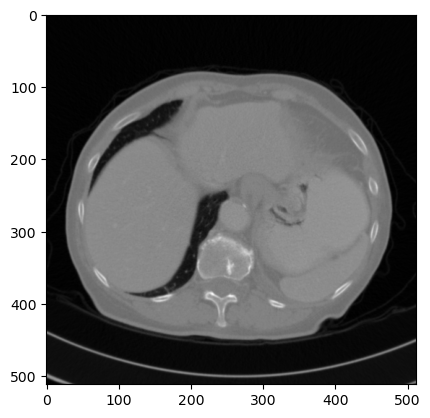

In [108]:
import matplotlib.pyplot as plt
import SimpleITK as sitk
img = sitk.ReadImage('../../Data/Mixed_HGP/Mixed_HGP_Raw/CILM_CT_100330_0000.nii.gz')
img_array = sitk.GetArrayFromImage(img)


plt.imshow(img_array[100,:,:],cmap='gray')

In [ ]:
img_arrary = sitk.GetArrayFromImage(img)

flip_img = sitk.Flip(img,[False,True,False])


#save flipped image

filp_array = sitk.GetArrayFromImage(flip_img)
plt.imshow(filp_array[90,:,:],cmap='gray')


In [6]:
image_orig_load = ImageLoad("../../Data/Mixed_HGP/Mixed_HGP/")
cropped_out_path = '../../Data/Mixed_HGP/Mixed_HGP/'


for i in tqdm(range(image_orig_load.images_num)):
    file_name = image_orig_load.images_names[i]
    image_path = image_orig_load.image_path[i]
    img_sitk = sitk.ReadImage(image_path)
    flip_img = sitk.Flip(img_sitk,[False,True,False])
    sitk.WriteImage(flip_img,cropped_out_path + file_name)

100%|██████████| 249/249 [15:29<00:00,  3.73s/it]


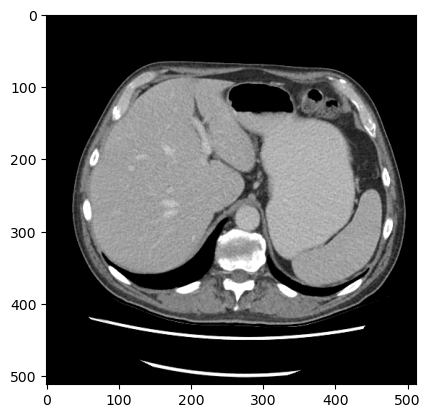